# Infer ***mitochondria*** - part 5️⃣

--------------
OBJECTIVE: ✅ Infer sub-cellular component  ***mitochondria***  in order to understand interactome 

Dependencies:
The ***mitochondria***  inference rely on the ***cytosol*** mask

## preamble

1. imports
2. setup
3. get cytosol mask
4. infer mitochondria
    * pre-processing
    * core processing
    * post processing
5. export mitochondria



## IMPORTS

In [11]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

from typing import Optional, Dict

import numpy as np

from aicssegmentation.core.utils import size_filter
from aicssegmentation.core.MO_threshold import MO

from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari
### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.utils.file_io import (read_czi_image, 
                                         read_ome_image,
                                         list_image_files, 
                                         import_inferred_organelle, 
                                         export_inferred_organelle)

from infer_subc_2d.utils.img import *
from infer_subc_2d.organelles import fixed_infer_soma_MCZ, fixed_infer_nuclei, infer_cytosol

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )              


## SETUP

In [13]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [14]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## GET CYTOSOL MASK



In [15]:

cytosol_mask = import_inferred_organelle("cytosol", meta_dict, out_data_path)

if cytosol_mask is None:
    nuclei =  fixed_infer_nuclei(img_data) 
    soma = fixed_infer_soma_MCZ(img_data, nuclei)
    nucleus_obj =  apply_mask(nuclei, soma) 
    cytosol_mask =  infer_cytosol(soma, nucleus_obj, erode_nuclei=False) 
    out_file_n = export_inferred_organelle(cytosol_mask, "cytosol", meta_dict, out_data_path)
    print(f"calculated cytosol mask. wrote {out_file_n}")
else:
    print(f"loaded cytosol mask from {out_data_path}")


loaded cytosol mask from /Users/ahenrie/Projects/Imaging/data/out


---------------------

## infer ***mitochondria***

## summary of steps (Workflow #1 & #2)

INPUT
- channel  2
- cytosol mask

PRE-PROCESSING
-  smoothe / remove noise

CORE-PROCESSING
-  'vesselness' enhancement
-  threshold objects

- POST-PROCESSING
  - apply mask
  - filter objects

OUTPUT
- inferred  ***mitochondria*** object


Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> Using Allen Cell Segmenter Tom20as a potential Mitochondria segmenter to start with  start from [Allen Cell](https://www.allencell.org/cell-observations/category/mitochondria).   using [seg_tomm20.py]("../../../../aics-segmentation/aicssegmentation/structure_wrapper/seg_tomm20.py")


## INPUT prototype

In [16]:

###################
# INPUT
###################
raw_mito = select_channel_from_raw(img_data, MITO_CH)


## PRE-PROCESSING prototype


In [20]:
###################
# PRE_PROCESSING
###################
med_filter_size = 3
gaussian_smoothing_sigma = 1.34
struct_img =  scale_and_smooth(raw_mito,
                                                    median_sz = med_filter_size, 
                                                    gauss_sig = gaussian_smoothing_sigma)

## CORE PROCESSING prototype

In [22]:
###################
# CORE_PROCESSING
###################


################################
## PARAMETERS for this step ##
vesselness_sigma = 1.5
vesselness_cutoff = 0.05
# 2d vesselness slice by slice
# response = vesselness_slice_by_slice(structure_img_smooth, sigmas=vesselness_sigma, cutoff=-1, tau=.75)
bw = vesselness_slice_by_slice(struct_img, sigma=vesselness_sigma, cutoff=vesselness_cutoff, tau=.75)

# # from Sec61b workflows - playground references Tom20
# f2_param = [[1.5, 0.16]]
# bw = filament_2d_wrapper(structure_img_smooth, f2_param)

## POST-PROCESSING prototype

In [23]:
###################
# POST_PROCESSING
###################
# mito_object = apply_mask(bw,cytosol_mask)

small_object_width = 3
mito_object = size_filter_linear_size(bw, 
                                                min_size= small_object_width)


#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [24]:
viewer = napari.Viewer()



In [26]:


viewer.add_image(
    raw_mito,
)

viewer.scale_bar.visible = True
viewer.add_image(
    struct_img,
)


<Image layer 'struct_img' at 0x16500c970>

In [14]:

viewer.add_image(
    mito_object,
)


<Image layer 'mito_object' at 0x15ef14a30>

In [28]:


viewer.add_image(
    bw,
)


<Image layer 'bw' at 0x16509f640>

## DEFINE `infer_mitochondria` function

Based on the _prototyping_ above define the function to infer the mitochondria.  


In [34]:
##########################
#  infer_mitochondria
##########################
def _infer_mitochondria(
                                in_img: np.ndarray,
                                median_sz: int,
                                gauss_sig: float,
                                vesselness_scale : float,
                                vesselness_cut : float,
                                small_obj_w: int,
                            ) -> np.ndarray:
    """
    Procedure to infer mitochondria from linearly unmixed input.

    Parameters
    ------------
    in_img:
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    vesselness_scale: 
        scale (log_sigma) for vesselness filter
    vesselness_cut: 
        threshold for vesselness fitered threshold
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing

    Returns
    -------------
    mitochondria_object
        mask defined extent of mitochondria object
    
    """
    mito_ch = MITO_CH
    ###################
    # EXTRACT
    ###################    
    mito = select_channel_from_raw(in_img, MITO_CH)
    ###################
    # PRE_PROCESSING
    ###################                         
    # mito = min_max_intensity_normalization(mito)
    # mito = median_filter_slice_by_slice(mito, size=median_sz)
    # struct_img = image_smoothing_gaussian_slice_by_slice( mito, sigma=gauss_sig )
    struct_img =  scale_and_smooth(mito,
                                                    median_sz = median_sz, 
                                                    gauss_sig = gauss_sig)
    ###################   
    # CORE_PROCESSING
    ###################
    struct_img = vesselness_slice_by_slice(struct_img, sigma=vesselness_scale, cutoff=vesselness_cut, tau=.75)

    ###################
    # POST_PROCESSING
    ###################
    # struct_obj = apply_mask(struct_img, cytosol_mask)
    struct_obj = size_filter_linear_size(struct_img, min_size=small_obj_w)
    return struct_obj



## DEFINE `_fixed_infer_mitochondria` function


In [36]:


##########################
#  fixed_infer_mitochondria
##########################
def _fixed_infer_mitochondria(in_img: np.ndarray ) -> np.ndarray:
    """
    Procedure to infer mitochondria from linearly unmixed input,
    
    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels

    Returns
    -------------
    mitochondria_object
        mask defined extent of mitochondria
    """
    median_sz = 3
    gauss_sig = 1.4
    vesselness_scale = 1.5
    vesselness_cut = 0.05
    small_obj_w = 3

    return _infer_mitochondria(  
                                in_img,
                                median_sz,
                                gauss_sig,
                                vesselness_scale,                                
                                vesselness_cut,
                                small_obj_w
                                )



------------------

# TEST `infer_mitochondria` function

In [37]:

_mito_object =  _fixed_infer_mitochondria(img_data) 

In [38]:
from infer_subc_2d.organelles import fixed_infer_mitochondria

mito_object =  fixed_infer_mitochondria(img_data, cytosol_mask) 

## Visualize  2


In [39]:

viewer.add_image(
    mito_object,
)


<Image layer 'mito_object' at 0x16704c5e0>

In [40]:

viewer.add_image(
    _mito_object,
)


<Image layer '_mito_object' at 0x16704c190>

In [41]:

viewer.add_labels(
    label(mito_object),
)

<Labels layer 'Labels' at 0x166fceb20>

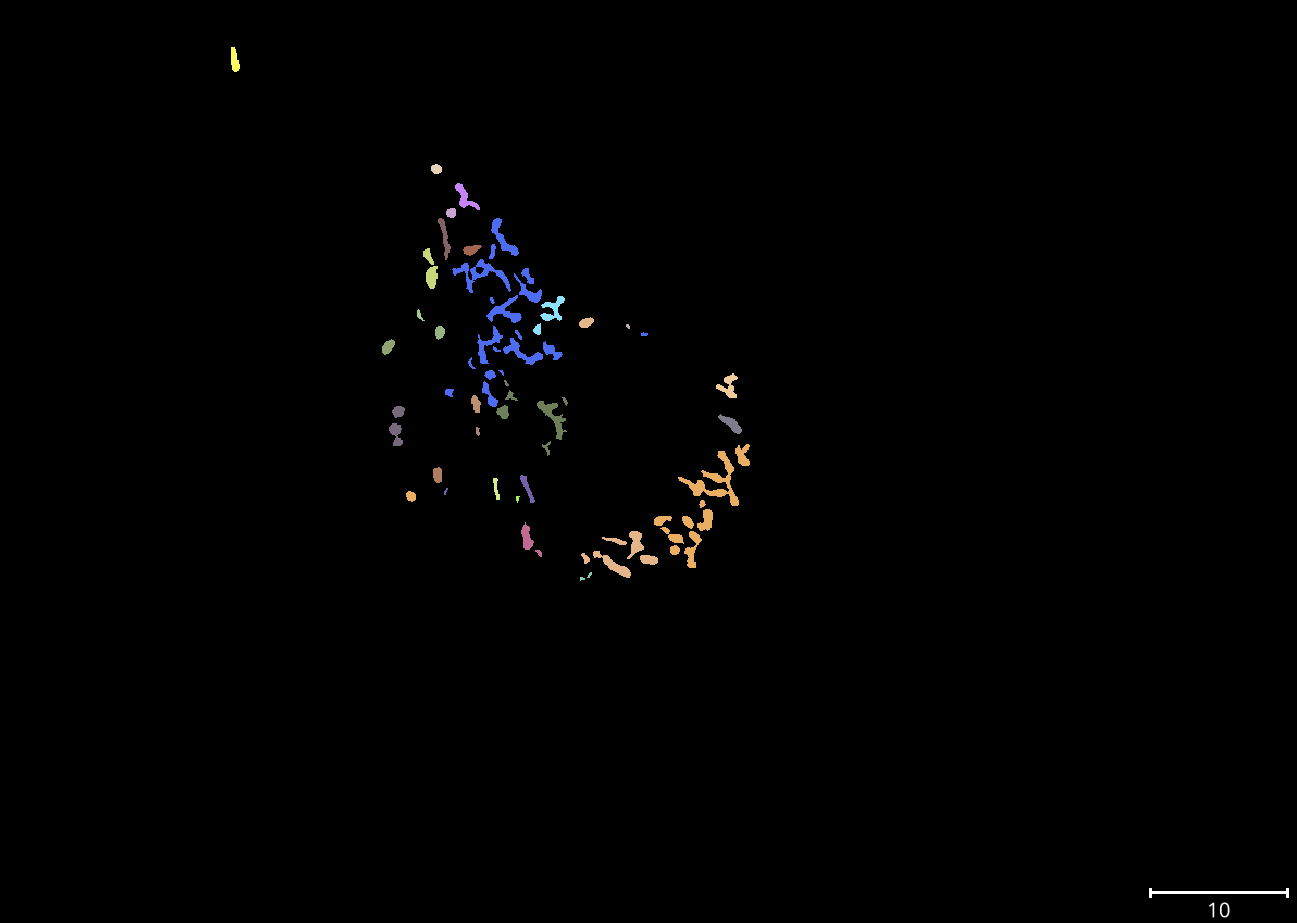

In [42]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [43]:
viewer.close()

-----------------
Write the `infer_lysosome` spec to the widget json 

In [ ]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_mitochondria =  {
        "name": "infer mitochondria  (fixed parameters)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "fixed_infer_mitochondria",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_mitochondria",_fixed_infer_mitochondria, overwrite=True)

function fixed_infer_mitochondria is already in all_functions.json
overwriting  fixed_infer_mitochondria


1

In [ ]:

_infer_mitochondria =  {
        "name": "infer mitochondria",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_mitochondria",
        "parameters": {
                "median_sz": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 3,
                        "max": 15,
                        "increment": 1
                },
                "gauss_sig": {
                        "data_type": "float",
                        "increment": 0.25,
                        "max": 15.0,
                        "min": 1.25,
                        "widget_type": "slider"
                },
                "vesselness_scale": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "vesselness_cut": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "small_obj_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                }
        }
}

add_function_spec_to_widget_json("infer_mitochondria", _infer_mitochondria, overwrite=True )



function infer_mitochondria is already in all_functions.json
overwriting  infer_mitochondria


1

##  helper function definitions

Wrappers for vessleness filters

In [ ]:

_vesselness_slice_by_slice =  {
        "name": "vesselness filter (e.g. mitochondria)",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "vesselness_slice_by_slice",
        "parameters": {
            "sigma": [
                {
                    "widget_type": "slider",
                    "data_type": "float",
                    "min": 0.5,
                    "max": 5,
                    "increment": 0.5
                }
            ],
            "cutoff": {
                "widget_type": "slider",
                "data_type": "float",
                "min": 0.005,
                "max": 0.5,
                "increment": 0.005
            }
        }
    }

add_function_spec_to_widget_json("vesselness_slice_by_slice", _vesselness_slice_by_slice, overwrite=True)


function vesselness_slice_by_slice is already in all_functions.json
overwriting  vesselness_slice_by_slice


1

-------------------------------
## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [ ]:
from infer_subc_2d.constants import MITO_CH 

def make_infer_mitochondria_step_by_step_from_raw_dict():
    """
    Procedure to infer mitochondria from linearly unmixed input from raw

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   

    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    step_name.append("2")
    function_name.append("fixed_infer_soma")
    category.append("extraction")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("fixed_infer_nuclei")
    category.append("extraction")
    parameter_values.append( None )
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytosol")
    category.append("extraction")
    parameter_values.append(dict(erode_nuclei = True ))
    parent.append([2,3])

    step_name.append("5")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = MITO_CH) )
    parent.append(1)

    
    step_name.append("6")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(5)

    step_name.append("7")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 3 ))
    parent.append(6)

    step_name.append("8")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.34 ))
    parent.append(7)


    step_name.append("9")
    function_name.append("vesselness_slice_by_slice") 
    category.append("core")
    parameter_values.append( dict( sigma=1.5, cutoff=0.05) )
    parent.append(8)


    step_name.append("10")
    function_name.append("apply_mask")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([9,4])

    step_name.append("11")
    function_name.append("size_filter_linear_size")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 3**2  ))
    parent.append(10)

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
    
    return out_dict



In [ ]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_mitochondria_stepbystep_from_raw_dict = make_infer_mitochondria_step_by_step_from_raw_dict()

write_workflow_json("conf_1.5.mitochondria_stepbystep_from_raw", infer_mitochondria_stepbystep_from_raw_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_1.5.mitochondria_stepbystep_from_raw.json')

-------------
## SUMMARY

The above details how the mitochondria object is inferred.  

### NEXT: INFER GOLGI

proceed to [06_infer_golgi.ipynb](./06_infer_golgi.ipynb)


---------------------

 🚧 WIP 🚧 (🚨🚨🚨🚨 )

# PUTATIVE ALTERNATE WORKFLOW #2 (WIP)
as per 6/22 CellProfiler pipeline from MCZ
 > ADAPTIVE... not sure exactly how to impliment this...

  >ReduceNoise performs non-local means noise reduction. Instead of only using a neighborhood of pixels around a central pixel for denoising, such as in GaussianFilter, multiple neighborhoods are pooled together. The neighborhood pool is determined by scanning the image for regions similar to the area around the central pixel using a correlation metric and a cutoff value.
   
## summary of steps (Workflow #1 & #2)

INPUT
- ch 3
- CY mask

PRE-PROCESSING
-  non-local noise reduction
  - size:4, distance:2, cut-off:0.1

CORE-PROCESSING
  - adaptive Otsu
    - diameter: (2,200)
  - two classes
    - threshold smoothing scale: 0
    - threshold correction factor: .1
    - threshold bounds: (0.14 1)
    - adaptive window: 20 pixels

POST-PROCESSING
  - N/A





### INPUT

In [ ]:

###################
# INPUT
###################
raw_mito    = img_2D[2].copy()

# mask object
masked_mito = apply_mask(raw_mito,CY_object)


### PRE-PROCESSING

In [ ]:
###################
# PRE_PROCESSING
###################

intensity_norm_param = [0] # 

# Linear-ish smoothing
raw_mito = intensity_normalization( masked_mito ,  scaling_param=intensity_norm_param)

med_filter_size =3  

gaussian_smoothing_sigma = 1.3
gaussian_smoothing_truncate_range = 3.0

struct_img = median_filter(raw_mito,    size=med_filter_size  )

structure_img_smooth = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                                        truncate_range=gaussian_smoothing_truncate_range,
                                                                                                                    )


# log_img, d = log_transform( structure_img_smooth ) 
# struct_img = intensity_normalization(  log_img  ,  scaling_param=[0] )  

struct_img = structure_img_smooth

### CORE PROCESSING

In [ ]:
###################
# CORE_PROCESSING
###################
# enhance spreckles - 40
big_struct_rad = 40
big_img = enhance_speckles(struct_img.copy(),big_struct_rad, True)

#adaptive_otsu(big_struct) # three class - middle foreground
# adaptive window- 20
#size: 10,100
# threshold smooth 1.34
# threshold correction 1
# threshold (0.1497,1)
#fill holes
# "adatpive" thresholds are NOT currently working... will use      
# "Masked Object Thresholding" - 3D
low_level_min_size = 10
bw_big, _bw_low_level = MO(big_img, 
                                                global_thresh_method='ave', 
                                                object_minArea=low_level_min_size, 
                                                extra_criteria=True,
                                                local_adjust= 0.5, 
                                                return_object=True,
                                                dilate=True)

In [ ]:

# enhance speckles
#   adaptive_sauvola(sm_struct) 
# adaptive window- 10
#size: 2,10
# threshold smooth 1.34
# threshold correction 1
# threshold (0.05,1)
#fill holes

# enhance spreckles - 10
sm_struct_rad = 20
sm_img = enhance_speckles(struct_img.copy(),sm_struct_rad, True)

# "adatpive" thresholds are NOT currently working... will use      
# "Masked Object Thresholding" - 3D
low_level_min_size = 2
bw_sm, _bw_low_level = MO(sm_img, 
                                                global_thresh_method='ave', 
                                                object_minArea=low_level_min_size, 
                                                extra_criteria=True,
                                                local_adjust= 0.5, 
                                                return_object=True,
                                                dilate=True)
 # or this?                                               
#    struct_obj = struct_img > filters.threshold_otsu(struct_img)
#     threshold_value_log = threshold_otsu_log(struct_img)
#     thresh_factor = 0.9 #from cellProfiler
#     thresh_min = .1
#     thresh_max = 1.
#     threshold = min( max(threshold_value_log*thresh_factor, thresh_min), thresh_max)
#     struct_obj = struct_img > threshold



### POST-PROCESSING

In [ ]:
###################
# POST_PROCESSING
###################


# 3D
# cleaned_img = remove_small_objects(removed_holes>0, 
#                                                             min_size=minArea, 
#                                                             connectivity=1, 
#                                                             in_place=False)
small_object_width = 10
cleaned_img_big = size_filter(bw_big, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_width**2,
                                                         method = "slice_by_slice",
                                                         connectivity=1)


#                                                             in_place=False)
small_object_width = 2
cleaned_img_sm = size_filter(bw_sm, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_width**2,
                                                         method = "slice_by_slice",
                                                         connectivity=1)



cleaned_img = np.logical_or(cleaned_img_big, cleaned_img_sm)

